In [141]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
path = '/Users/tina/Documents/LUMEN/dnevna_popunjenost_hotel0_2016.csv'
df = pd.read_csv(path)


In [142]:
#provjera stacionarnosti vremenske serije koristeći Augmented Dickey-Fuller (ADF) test
result = adfuller(df['ukupan_broj_gostiju'])
# Ispis rezultata
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')

# Interpretacija rezultata
if result[1] < 0.05:
    print("\nSerija je stacionarna.")
else:
    print("\nSerija nije stacionarna i treba je diferencirati")
#pocetna hipoteza je da serija nije stacionarna. ADF statistika mora biti manja od kriticnih vrijednosti kako bi mogli
#odbaciti pocetnu hipotezu sa 99%, 95% ili 90% sigurnosti
#posto je ADF statistika veca od krtiicnih vrijednosti ne mozemo odbaciti hipotezu i moramo diferencirati podatke

ADF Statistic: -2.0672693314890958
p-value: 0.25787774149895804
Critical Values:
   1%: -3.44911857009962
   5%: -2.8698097654570507
   10%: -2.5711757061225153

Serija nije stacionarna i treba je diferencirati


In [26]:
df.head()

,datum,ukupan_broj_gostiju,broj_djece_gostiju,broj_odraslih_gostiju
0,2016-01-01,24,6,18
1,2016-01-02,92,3,89
2,2016-01-03,98,2,96
3,2016-01-04,132,1,131
4,2016-01-05,115,1,114


In [18]:
#ADF test za broj odraslih
result_odrasli = adfuller(df['broj_odraslih_gostiju'])
print('ADF Statistic:', result_odrasli[0])
print('p-value:', result_odrasli[1])
print('Critical Values:')
for key, value in result_odrasli[4].items():
    print(f'   {key}: {value}')

# Interpretacija rezultata
if result_odrasli[1] < 0.05:
    print("\nSerija je stacionarna.")
else:
    print("\nSerija nije stacionarna i treba je diferencirati")

ADF Statistic: -2.095675212862444
p-value: 0.246257172508683
Critical Values:
   1%: -3.44911857009962
   5%: -2.8698097654570507
   10%: -2.5711757061225153

Serija nije stacionarna i treba je diferencirati


In [143]:
#diferenciranje podataka
df['diferencirano_ukupno'] = df['ukupan_broj_gostiju'].diff()
df.to_csv('/Users/tina/Documents/LUMEN/dnevna_popunjenost_diferencirano_hotel0_2016.csv', index=False)
df_dif = pd.read_csv('/Users/tina/Documents/LUMEN/dnevna_popunjenost_diferencirano_hotel0_2016.csv')

In [144]:

df_dif.head()

,datum,ukupan_broj_gostiju,broj_djece_gostiju,broj_odraslih_gostiju,diferencirano_ukupno
0,2016-01-01,24,6,18,NaN
1,2016-01-02,92,3,89,68.0
2,2016-01-03,98,2,96,6.0
3,2016-01-04,132,1,131,34.0
4,2016-01-05,115,1,114,-17.0


In [44]:
#ponovljeni ADF test na diferenciranim podatcima 
df_dif = df_dif.dropna()
result = adfuller(df_dif['diferencirano_ukupno'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')

# Interpretacija rezultata
if result[1] < 0.05:
    print("\nSerija je stacionarna.")
else:
    print("\nSerija nije stacionarna i treba je diferencirati")

ADF Statistic: -5.381881631072805
p-value: 3.6969971945827884e-06
Critical Values:
   1%: -3.44911857009962
   5%: -2.8698097654570507
   10%: -2.5711757061225153

Serija je stacionarna.


In [45]:
#Kreiranje ACF (Autocorrelation Function) i PACF (Partial Autocorrelation Function) grafikona koji nam sluze
#za odredivanje p i q parametara u ARIM-i


<Figure size 1000x600 with 0 Axes>

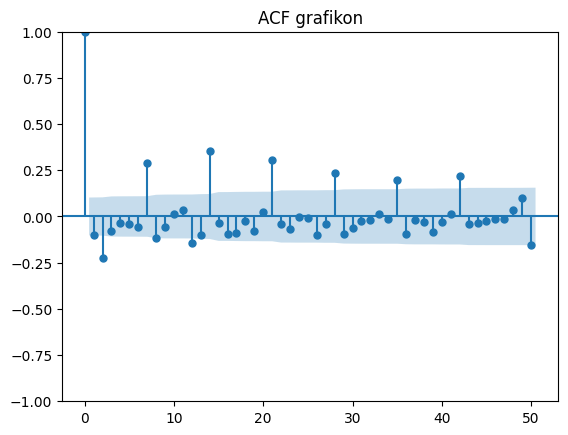

In [56]:
#ACF grafikon
plt.figure(figsize=(10, 6))
plot_acf(df_dif['diferencirano_ukupno'], lags=50)
plt.title('ACF grafikon')
plt.show()

<Figure size 1000x600 with 0 Axes>

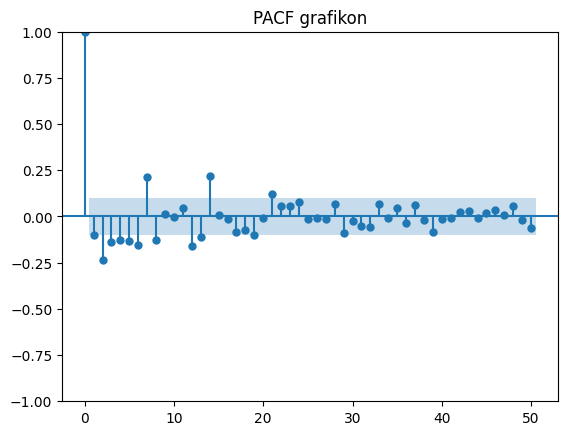

In [59]:
#PACF grafikon
plt.figure(figsize=(10, 6))
plot_pacf(df_dif['diferencirano_ukupno'], lags=50)
plt.title('PACF grafikon')
plt.show()

In [71]:
df_dif.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   datum                  366 non-null    datetime64[ns]
 1   ukupan_broj_gostiju    366 non-null    int64         
 2   broj_djece_gostiju     366 non-null    int64         
 3   broj_odraslih_gostiju  366 non-null    int64         
 4   diferencirano_ukupno   365 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 14.4 KB


In [146]:
df_dif['datum'] = pd.to_datetime(df_dif['datum'])

In [147]:
training_df_dif = df_dif[df_dif['datum'].dt.month<=9]

In [148]:
training_df_dif = training_df_dif.dropna()
training_df_dif.info()


<class 'pandas.core.frame.DataFrame'>
Index: 273 entries, 1 to 273
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   datum                  273 non-null    datetime64[ns]
 1   ukupan_broj_gostiju    273 non-null    int64         
 2   broj_djece_gostiju     273 non-null    int64         
 3   broj_odraslih_gostiju  273 non-null    int64         
 4   diferencirano_ukupno   273 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 12.8 KB


In [149]:
training_df_dif.to_csv('/Users/tina/Documents/LUMEN/training_data2016.csv')
training = pd.read_csv('/Users/tina/Documents/LUMEN/training_data2016.csv', index_col = 'datum', parse_dates = True)
#training = training.drop(training.columns[0], axis=1)
training.head()

,Unnamed: 0,ukupan_broj_gostiju,broj_djece_gostiju,broj_odraslih_gostiju,diferencirano_ukupno
datum,,,,,
2016-01-02,1,92,3,89,68.0
2016-01-03,2,98,2,96,6.0
2016-01-04,3,132,1,131,34.0
2016-01-05,4,115,1,114,-17.0
2016-01-06,5,110,0,110,-5.0


In [135]:
stepwise_fit = autoarima(training['ukupan_broj_gostiju'])
